In [ ]:
import os
import glob
import random
import warnings
import numpy as np

import matplotlib.pyplot as plt

import sys
from tqdm import tqdm
import cv2





In [ ]:
import ants #install ANtspyx
 

In [ ]:
from natsort import natsorted, ns

In [ ]:
import scipy.io as sio


In [ ]:
def dice(vol1, vol2, labels=None, nargout=1):
    '''
    Dice [1] volume overlap metric

    The default is to *not* return a measure for the background layer (label = 0)

    [1] Dice, Lee R. "Measures of the amount of ecologic association between species."
    Ecology 26.3 (1945): 297-302.

    Parameters
    ----------
    vol1 : nd array. The first volume (e.g. predicted volume)
    vol2 : nd array. The second volume (e.g. "true" volume)
    labels : optional vector of labels on which to compute Dice.
        If this is not provided, Dice is computed on all non-background (non-0) labels
    nargout : optional control of output arguments. if 1, output Dice measure(s).
        if 2, output tuple of (Dice, labels)

    Output
    ------
    if nargout == 1 : dice : vector of dice measures for each labels
    if nargout == 2 : (dice, labels) : where labels is a vector of the labels on which
        dice was computed
    '''
    if labels is None:
        labels = np.unique(np.concatenate((vol1, vol2)))
        labels = np.delete(labels, np.where(labels == 0))  # remove background

    dicem = np.zeros(len(labels))
    for idx, lab in enumerate(labels):
        vol1l = vol1 == lab
        vol2l = vol2 == lab
        top = 2 * np.sum(np.logical_and(vol1l, vol2l))
        bottom = np.sum(vol1l) + np.sum(vol2l)
        bottom = np.maximum(bottom, np.finfo(float).eps)  # add epsilon.
        dicem[idx] = top / bottom

    if nargout == 1:
        return dicem
    else:
        return (dicem, labels)

In [ ]:
from numpy.lib.stride_tricks import as_strided

def pool2d(A, kernel_size, stride, padding, pool_mode='max'):
    '''
    2D Pooling

    Parameters:
        A: input 2D array
        kernel_size: int, the size of the window
        stride: int, the stride of the window
        padding: int, implicit zero paddings on both sides of the input
        pool_mode: string, 'max' or 'avg'
    '''
    # Padding
    A = np.pad(A, padding, mode='constant')

    # Window view of A
    output_shape = ((A.shape[0] - kernel_size)//stride + 1,
                    (A.shape[1] - kernel_size)//stride + 1)
    kernel_size = (kernel_size, kernel_size)
    A_w = as_strided(A, shape = output_shape + kernel_size, 
                        strides = (stride*A.strides[0],
                                   stride*A.strides[1]) + A.strides)
    A_w = A_w.reshape(-1, *kernel_size)

    # Return the result of pooling
    if pool_mode == 'max':
        return A_w.max(axis=(1,2)).reshape(output_shape)
    elif pool_mode == 'avg':
        return A_w.mean(axis=(1,2)).reshape(output_shape)

In [ ]:
#all data is affinely aligned

In [ ]:
norm_val = np.load('test_norm_OAS_raw.npy')
seg_val = np.load('test_seg_OAS_raw.npy')

vol_shape = norm_val.shape[1:]
print('train shape:', norm_val.shape)
print(vol_shape)
vol_size=vol_shape

train shape: (300, 160, 192)
(160, 192)


#Labels over which we want to compute DICE score i.e labels from segmentation

In [ ]:
#labels = sio.loadmat('/data/labels.mat')['labels'][0]
#labels

In [ ]:
# labels=[2,3,4,10,16,17,24,28,31,41,42,43,49,53,60]
# labels

In [ ]:
labels=[2,3,4,7,8,41,42,43,46,47,53,251]

In [ ]:
norm_val.shape

(300, 160, 192)

In [ ]:
divide_avg=160*192


In [ ]:
input_seg1 = (seg_val[0,...])

input_seg2 = (seg_val[1,...])
input_seg2.shape

input_norm1 = (norm_val[0,...])
input_norm1.shape

input_norm2 = (norm_val[1,...])
input_norm2.shape

fixed_norm=ants.from_numpy(input_norm1)
moving_norm = ants.from_numpy(input_norm2)

fixed_seg=ants.from_numpy(input_seg1)
moving_seg = ants.from_numpy(input_seg2)

In [ ]:
norm_val.shape[0]

300

In [ ]:

    

vals_record=[]
valsbfr_record=[]

file2 = open(("/home/hassanmahmood/work/march/march_voxelmoprh/voxelmorph-master/pytorch/intesity_test_check_trends_ANTs/testing_first_intesity_testOAS__2D_avg_CC_demons.txt"),"w") 
L2 = ["intensity_test,        Before ,   After  ,  DICE_after , DICE_before"] 
                # dice_without_pre  
file2.writelines(L2) 
file2.write('\n')




for i in range(1,norm_val.shape[0]) :

    input_norm2 = (norm_val[i,...])
    moving_norm = ants.from_numpy(input_norm2)

    input_seg2 = seg_val[i,...]
    moving_seg = ants.from_numpy(input_seg2)
    
    demonsMetric = ['demons', fixed_norm, moving_norm, 1, 1]

    ccMetric = ['CC', fixed_norm, moving_norm, 2, 4 ]
    metrics = list( )
   # metrics.append( ccMetric )
   # metrics.append( demonsMetric )


    mytxsyn = ants.registration(fixed=fixed_norm , moving=moving_norm, type_of_transform='SyNOnly', grad_step=0.25 , reg_iterations=(1000,1000,1000,1000),flow_sigma=9,total_sigma=0.2, multivariate_extras = metrics )
    warped_norm_movingsyn = mytxsyn['warpedmovout']



    #aftr=sum(sum(abs(warped_norm_movingsyn.numpy()-fixed_norm.numpy())))/30720

   # bfr=sum(sum(abs(moving_norm.numpy()-fixed_norm.numpy())))/30720

    aftr=sum(sum(abs(pool2d(fixed_norm.numpy(), 5, 1, 0, pool_mode='avg')-pool2d(warped_norm_movingsyn.numpy(), 5, 1, 0, pool_mode='avg'))))/30720

    bfr=sum(sum(abs(pool2d(fixed_norm.numpy(), 5, 1, 0, pool_mode='avg')-pool2d(moving_norm.numpy(), 5, 1, 0, pool_mode='avg'))))/30720


    mywarped_seg_syn = ants.apply_transforms(fixed=fixed_norm, moving=moving_seg,
                                  transformlist=mytxsyn['fwdtransforms'],interpolator='nearestNeighbor')

    vals, _ = dice(mywarped_seg_syn.numpy(), fixed_seg.numpy(), labels=labels, nargout=2)
    vals_record=vals.mean()
    print("dice after")
    print(vals_record)
    
    
    valsbfr, _ = dice(moving_seg.numpy(), fixed_seg.numpy(), labels=labels, nargout=2)
    valsbfr_record=valsbfr.mean()
    print("dice before")
    print(valsbfr_record)
    
    L23 = str(i)+","+str(bfr)[0:8]+","+str(aftr)[0:8]+","+str(vals_record)[0:8]+","+str(valsbfr_record)[0:8]
    file2.writelines(L23) 
    file2.write('\n')
        
        
L24 = "hyper  "
file2.writelines(L24) 
file2.write('\n')
file2.close()


dice after
0.6406971899220392
dice before
0.5228743870778546
dice after
0.6963165883791721
dice before
0.5256901353383577
dice after
0.6182107079392535
dice before
0.4828382659205021


KeyboardInterrupt: 

This file Finished HERE ......................................
OPEN comma sperated file in excel sheet. sort in ascending order AFTER column. plot" AFTER "column and "DICE after" column sepratley
### Below check of intensity change on dice score **bold text**

In [ ]:
from PIL import Image, ImageDraw, ImageFilter

In [ ]:
def mask_circle_solid(pil_img, background_color, blur_radius, offset=0):
   # background = Image.new(pil_img.mode, pil_img.size, background_color)

    offset = blur_radius * 2 + offset
    mask = Image.new("L", pil_img.shape, 0)
    draw = ImageDraw.Draw(mask)
    draw.ellipse((offset, offset, pil_img.shape[0] - offset, pil_img.shape[1] - offset), fill=240)
    mask = mask.filter(ImageFilter.GaussianBlur(blur_radius))
    return mask
    #return Image.composite(pil_img, background, mask)

In [ ]:
zz=np.zeros([192, 160])#([160, 192])#, 224])

In [ ]:
im_thumb = mask_circle_solid(zz, 0,35, 3)
im_thumb=np.asarray(im_thumb) /255

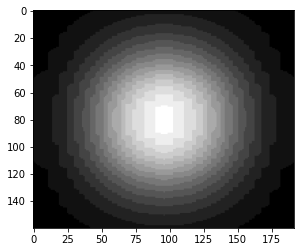

In [ ]:
plt.imshow(im_thumb,cmap='gray')

In [ ]:
np.max(im_thumb)

0.058823529411764705

In [ ]:
input_seg1 = (seg_val[0,...])

input_seg2 = (seg_val[1,...])
input_seg2.shape

input_norm1 = (norm_val[0,...])
input_norm1.shape

input_norm2 = (norm_val[1,...])
input_norm2.shape


(160, 192)

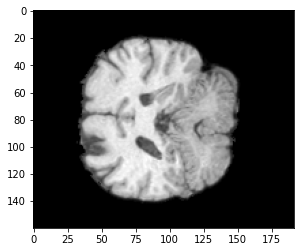

In [ ]:
plt.imshow(input_norm1,cmap='gray')

In [ ]:
input_norm1_biased=input_norm1+im_thumb 

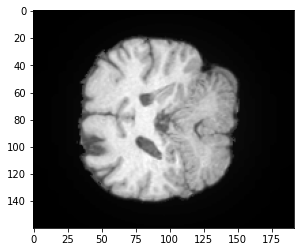

In [ ]:
plt.imshow(input_norm1_biased,cmap='gray')

In [ ]:
fixed_norm=ants.from_numpy(input_norm1)
fixed_norm_biased=ants.from_numpy(input_norm1_biased)
moving_norm = ants.from_numpy(input_norm2)

fixed_seg=ants.from_numpy(input_seg1)
moving_seg = ants.from_numpy(input_seg2)


before adding bias

In [ ]:

mytxsyn = ants.registration(fixed=fixed_norm , moving=moving_norm, type_of_transform='SyNOnly', grad_step=0.25 , reg_iterations=(1000,1000,1000,1000),flow_sigma=9,total_sigma=0.2, multivariate_extras = metrics )
warped_norm_movingsyn = mytxsyn['warpedmovout']


mywarped_seg_syn = ants.apply_transforms(fixed=fixed_norm, moving=moving_seg,
                          transformlist=mytxsyn['fwdtransforms'],interpolator='nearestNeighbor')

vals, _ = dice(mywarped_seg_syn.numpy(), fixed_seg.numpy(), labels=labels, nargout=2)
vals_record=vals.mean()
print(vals_record)

0.6406971899220392


After adding bias

In [ ]:

mytxsyn = ants.registration(fixed=fixed_norm_biased , moving=moving_norm, type_of_transform='SyNOnly', grad_step=0.25 , reg_iterations=(1000,1000,1000,1000),flow_sigma=9,total_sigma=0.2, multivariate_extras = metrics )
warped_norm_movingsyn = mytxsyn['warpedmovout']


mywarped_seg_syn = ants.apply_transforms(fixed=fixed_norm, moving=moving_seg,
                          transformlist=mytxsyn['fwdtransforms'],interpolator='nearestNeighbor')

vals, _ = dice(mywarped_seg_syn.numpy(), fixed_seg.numpy(), labels=labels, nargout=2)
vals_record=vals.mean()
print(vals_record)

0.6348943367316848


In [ ]:
from scipy.ndimage import gaussian_filter

0.5

In [ ]:
result = gaussian_filter(im_thumb, sigma=6)

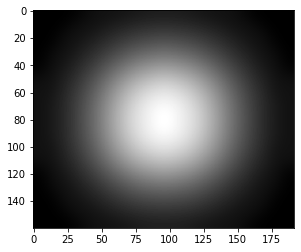

In [ ]:
plt.imshow(result,cmap='gray')

In [ ]:
res=result+input_norm1
np.max(res)

0.509079906228567

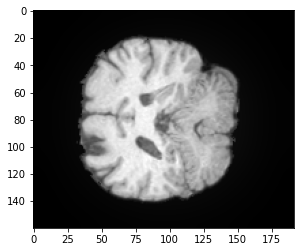

In [ ]:
plt.imshow(res,cmap='gray')

In [ ]:
fixed_norm_biased=ants.from_numpy(res)


In [ ]:

mytxsyn = ants.registration(fixed=fixed_norm_biased , moving=moving_norm, type_of_transform='SyNOnly', grad_step=0.25 , reg_iterations=(1000,1000,1000,1000),flow_sigma=9,total_sigma=0.2, multivariate_extras = metrics )
warped_norm_movingsyn = mytxsyn['warpedmovout']


mywarped_seg_syn = ants.apply_transforms(fixed=fixed_norm, moving=moving_seg,
                          transformlist=mytxsyn['fwdtransforms'],interpolator='nearestNeighbor')

vals, _ = dice(mywarped_seg_syn.numpy(), fixed_seg.numpy(), labels=labels, nargout=2)
vals_record=vals.mean()
print(vals_record)

0.6372045145719861


BIAS EFFECT FINISHED HERE
DOWN below is scrap.....

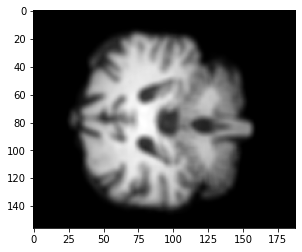

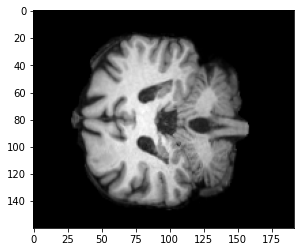

In [ ]:
A = np.array([[1, 1, 2, 4],
                  [5, 6, 7, 8],
                  [3, 2, 1, 0],
                  [1, 2, 3, 4]])
A

array([[1, 1, 2, 4],
       [5, 6, 7, 8],
       [3, 2, 1, 0],
       [1, 2, 3, 4]])

In [ ]:
pool2d(A, kernel_size=2, stride=1, padding=0, pool_mode='max')

array([[6, 7, 8],
       [6, 7, 8],
       [3, 3, 4]])

In [ ]:

img = cv2.imread('opencv_logo.png')

kernel = np.ones((5,5),np.float32)/25
dst = cv2.filter2D(img,-1,kernel)

plt.subplot(121),plt.imshow(img),plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(dst),plt.title('Averaging')
plt.xticks([]), plt.yticks([])
plt.show()



In [ ]:
input_norm1.detach().cpu().numpy().shape

(1, 1, 160, 192)

In [ ]:
source = input_norm1.detach().cpu().numpy().flatten()
template = warp.detach().cpu().numpy().flatten()
# get the set of unique pixel values and their corresponding indices and
# counts
s_values, sbin_idx, s_counts = np.unique(source, return_inverse=True,return_counts=True)
                                        
t_values, tbin_idx, t_counts = np.unique(template,return_inverse=True, return_counts=True)

In [ ]:
s_quantiles = np.cumsum(s_counts).astype(np.float64)
s_quantiles /= s_quantiles[-1]
t_quantiles = np.cumsum(t_counts).astype(np.float64)
t_quantiles /= t_quantiles[-1]

In [ ]:
s_quantiles

array([0.46246745, 0.4625    , 0.46253255, ..., 0.9999349 , 0.99996745,
       1.        ])

In [ ]:
t_quantiles

array([0.45745443, 0.45748698, 0.45751953, ..., 0.9999349 , 0.99996745,
       1.        ])

ValueError: x and y must have same first dimension, but have shapes (16505,) and (16659,)

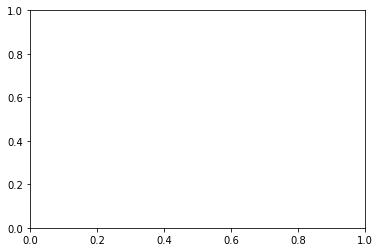

In [ ]:
plt.plot(s_quantiles,t_quantiles)

In [ ]:
print(sum(abs(source-template))/30720)

0.0117334248466331


In [ ]:
print(sum(abs(sbin_idx-tbin_idx))/30720)

406.23619791666664


In [ ]:
max(source)


0.487399

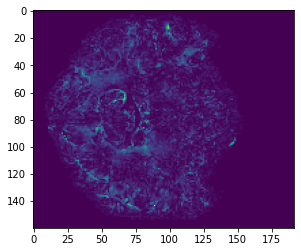

In [ ]:
plt.imshow((abs(sbin_idx-tbin_idx).reshape(160, 192))/30720)

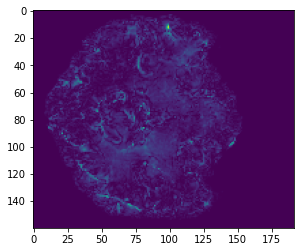

In [ ]:
plt.imshow((abs(source-template).reshape(160, 192)))

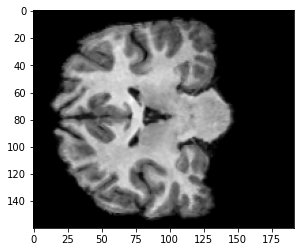

In [ ]:
plt.imshow( input_norm2.detach().cpu().numpy()[0,0,...],'gray')

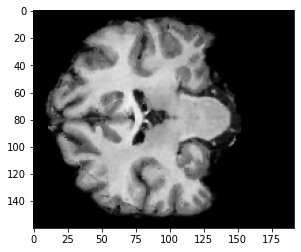

In [ ]:
plt.imshow( warp.detach().cpu().numpy()[0,0,...],'gray')

In [ ]:
x_data.flatten().reshape(1000, 12288)

In [ ]:
tbin_idx.reshape(160, 192)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
a = np.array([1, 2, 3, 4, 2, 3, 2])
b = np.array([1, 3, 2, 4, 2, 3, 2])

u, indices ,c= np.unique(a, return_inverse=True,return_counts=True)
ub, indicesb ,cb= np.unique(b, return_inverse=True,return_counts=True)

In [ ]:
u

array([1, 2, 3, 4])

In [ ]:
indices

array([0, 1, 2, 3, 1, 2, 1])

In [ ]:
c

array([1, 3, 2, 1])

In [ ]:
print(ub , indicesb ,cb)

[1 2 3 4] [0 2 1 3 1 2 1] [1 3 2 1]


In [ ]:
abs(indicesb-indices)

array([0, 1, 1, 0, 0, 0, 0])

In [ ]:
def hist_match(source, template):
    """
    Adjust the pixel values of a grayscale image such that its histogram
    matches that of a target image

    Arguments:
    -----------
        source: np.ndarray
            Image to transform; the histogram is computed over the flattened
            array
        template: np.ndarray
            Template image; can have different dimensions to source
    Returns:
    -----------
        matched: np.ndarray
            The transformed output image
    """

    oldshape = source.shape
    source = source.ravel()
    template = template.ravel()

    # get the set of unique pixel values and their corresponding indices and
    # counts
    s_values, bin_idx, s_counts = np.unique(source, return_inverse=True,
                                            return_counts=True)
    t_values, t_counts = np.unique(template, return_counts=True)

    # take the cumsum of the counts and normalize by the number of pixels to
    # get the empirical cumulative distribution functions for the source and
    # template images (maps pixel value --> quantile)
    s_quantiles = np.cumsum(s_counts).astype(np.float64)
    s_quantiles /= s_quantiles[-1]
    t_quantiles = np.cumsum(t_counts).astype(np.float64)
    t_quantiles /= t_quantiles[-1]

    # interpolate linearly to find the pixel values in the template image
    # that correspond most closely to the quantiles in the source image
    interp_t_values = np.interp(s_quantiles, t_quantiles, t_values)

    return interp_t_values[bin_idx].reshape(oldshape)